In [1]:
import anndata as ad
import scanpy as sc
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import polars as pl
import mudata
import os
import gseapy
mudata.set_options(pull_on_update=False)

In [2]:
acc2gene = pd.read_table('external_data/acc2name.txt', sep='\t', header=None)
acc2gene.columns = ['acc', 'name']
acc2gene.index = acc2gene['acc']
del acc2gene['acc']
acc2gene = acc2gene.to_dict()['name']
gene2acc = {v: k for k, v in acc2gene.items()}
tid2gid = pd.read_table('external_data/gid2tid.txt', sep='\t', header=None)
tid2gid.columns = ['gid', 'tid']
tid2gid.index = tid2gid['tid']
del tid2gid['tid']
tid2gid = tid2gid.to_dict()['gid']
gid2tid = {v:k for k,v in tid2gid.items()}

In [3]:
qc = sp.io.mmread('mudata/clark/scNMT.meth.qc.mtx').tocoo()
qc_dense = np.full(qc.shape, np.nan)
qc_dense[qc.row, qc.col] = qc.data
obs = pd.read_table('mudata/clark/scNMT.meth.meta.tsv')
qc_dense = qc_dense[list(obs[obs['class'] == 'promoters'].index)]
qc_dense = qc_dense[np.sum(~np.isnan(qc_dense), axis=1) >= 10]
qc_dense

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan, 0.08333334, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], shape=(246, 2000))

In [4]:
adata = mudata.read_h5mu("mudata/clark/scNMT.h5mu")
newix = []
for _ in adata.var.index:
    if _ in acc2gene:
        newix.append(acc2gene[_])
    else:
        newix.append(_)
adata.var['gene_name'] = newix
newix = []
for _ in adata['RNA'].var.index:
    if _ in acc2gene:
        newix.append(acc2gene[_])
    else:
        newix.append(_)
adata['RNA'].var['gene_name'] = newix
adata['RNA'].var_names = newix
adata['RNA'].var_names_make_unique()
adata.raw = adata.copy()

In [5]:
adata['METH'].var['genes_name'] = adata['METH'].var.index.map(tid2gid).map(acc2gene)
adata['ACC'].var['genes_name'] = adata['ACC'].var.index.map(tid2gid).map(acc2gene)

In [6]:
sc.pp.normalize_total(adata['RNA'])
sc.pp.log1p(adata['RNA'])
sc.pp.highly_variable_genes(adata['RNA'], n_top_genes=5000)

/localenv/deboutte/anaconda/miniconda/envs/linkapy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


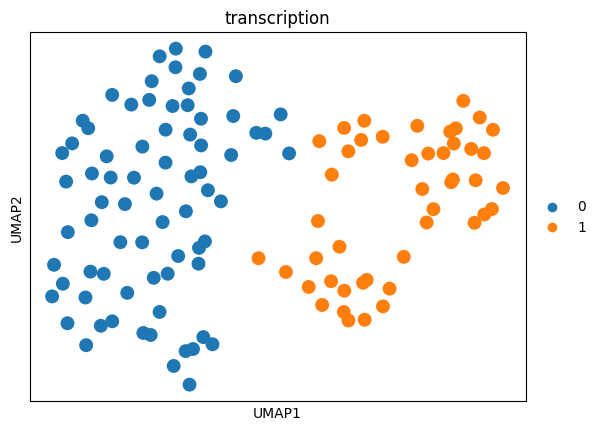

In [7]:
sc.pp.highly_variable_genes(adata['RNA'], n_top_genes=5000)
sc.pp.pca(adata['RNA'])

# Compute nearest neighbors (needed for UMAP)
sc.pp.neighbors(adata['RNA'], n_neighbors=10, n_pcs=20)
sc.tl.leiden(adata['RNA'], resolution=0.2, flavor="igraph", n_iterations=2)
# Compute UMAP
sc.tl.umap(adata['RNA'])
adata['RNA'].obs['transcription'] = adata['RNA'].obs['leiden']
sc.pl.umap(adata['RNA'], color=['transcription'], size=400, save='clark_umap_RNA.png')

/localenv/deboutte/anaconda/miniconda/envs/linkapy/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


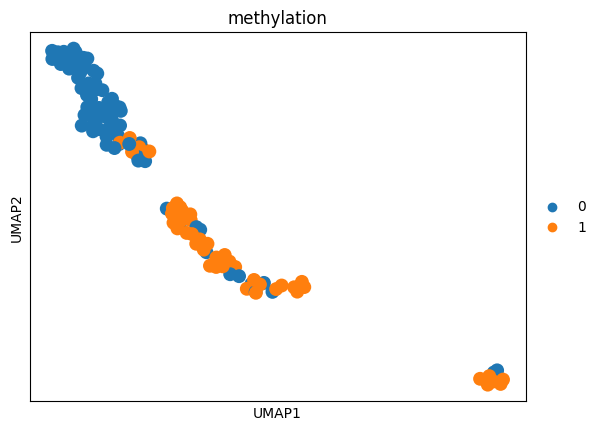

In [8]:
PROM_GB = list(adata['METH'].var[adata['METH'].var['class'].isin(['genes'])].index)

_ = adata['METH'][:, PROM_GB]
_.X = np.nan_to_num(_.X, nan=0.0)
_.X
sc.pp.normalize_total(_)
sc.pp.pca(_)
sc.pp.neighbors(_, n_neighbors=10, n_pcs=20)
sc.tl.umap(_)
_.obs['methylation'] = adata['RNA'].obs['leiden']
sc.pl.umap(_, color=['methylation'], size=400, save='clark_umap_meth.png')

/localenv/deboutte/anaconda/miniconda/envs/linkapy/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


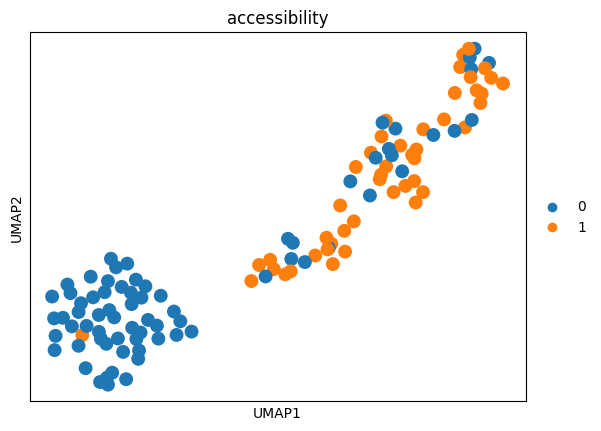

In [9]:
PROM_GB = list(adata['ACC'].var[adata['ACC'].var['class'].isin(['genes'])].index)

_ = adata['ACC'][:, PROM_GB]
_.X = np.nan_to_num(_.X, nan=0.0)
_.X
sc.pp.normalize_total(_)
sc.pp.pca(_)
sc.pp.neighbors(_, n_neighbors=10, n_pcs=20)
sc.tl.umap(_)
_.obs['accessibility'] = adata['RNA'].obs['leiden']
sc.pl.umap(_, color=['accessibility'], size=400, save='clark_umap_acc.png')

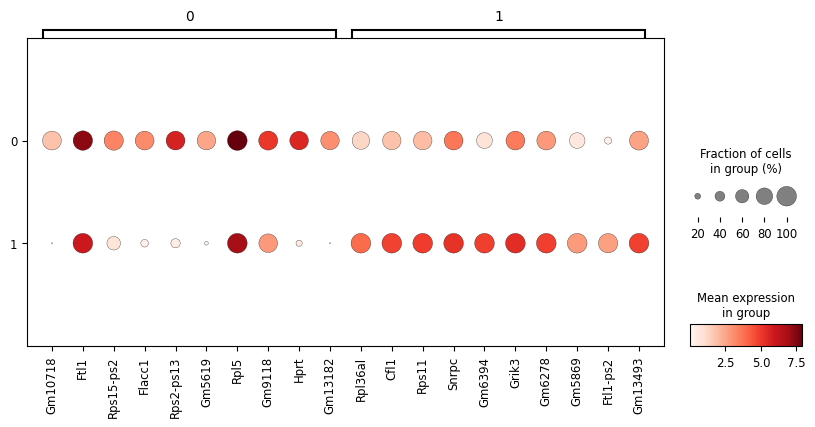

In [10]:
sc.tl.rank_genes_groups(adata['RNA'], "leiden", method="wilcoxon")
sc.pl.rank_genes_groups_dotplot(adata['RNA'],n_genes=10, figsize=(10,4), save='clark_wilcox_RNA.png')

In [11]:
cluster = '0'
rank_genes_df = pd.DataFrame({
    'gene': adata['RNA'].uns['rank_genes_groups']['names'][cluster],
    'logfoldchanges': adata['RNA'].uns['rank_genes_groups']['logfoldchanges'][cluster],
    'pvals': adata['RNA'].uns['rank_genes_groups']['pvals'][cluster],
    'pvals_adj': adata['RNA'].uns['rank_genes_groups']['pvals_adj'][cluster],
    'scores': adata['RNA'].uns['rank_genes_groups']['scores'][cluster]
})
rank_genes_df['group'] = cluster
cl0_genes = rank_genes_df[(rank_genes_df['logfoldchanges'] > 0) & (rank_genes_df['pvals_adj'] < 0.01)]['gene'].str.upper().tolist()
cl1_genes = rank_genes_df[(rank_genes_df['logfoldchanges'] < 0) & (rank_genes_df['pvals_adj'] < 0.01)]['gene'].str.upper().tolist()

enr_cl0 = gseapy.enrichr(
    gene_list=cl0_genes,
    gene_sets='GO_Biological_Process_2025',
    organism='Mouse',
    outdir=None
)

enr_cl1 = gseapy.enrichr(
    gene_list=cl1_genes,
    gene_sets='GO_Biological_Process_2025',
    organism='Mouse',
    outdir=None
)

enr_cl0_df = enr_cl0.results[enr_cl0.results['Adjusted P-value'] < 0.01].sort_values('Combined Score', ascending=False).head(5)
enr_cl0_df['gene_class'] = 'cluster0'
enr_cl1_df = enr_cl1.results[enr_cl1.results['Adjusted P-value'] < 0.01].sort_values('Combined Score', ascending=False).head(5)
enr_cl1_df['gene_class'] = 'cluster1'

enrr = pd.concat(
    [
        enr_cl0_df,
        enr_cl1_df
    ]
)

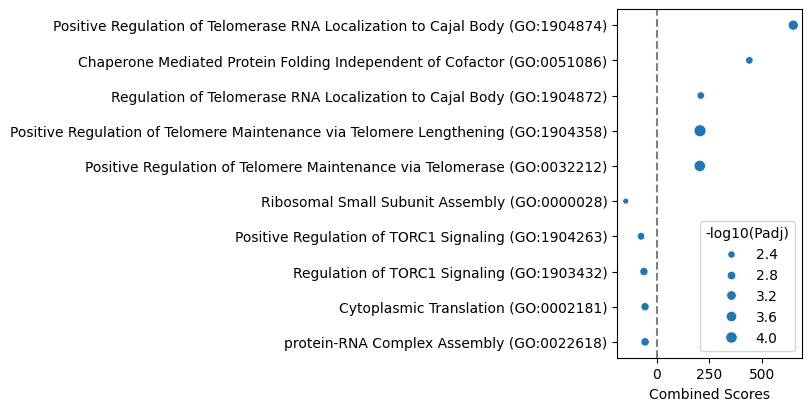

In [12]:
cs = []
enrr['-log10(Padj)'] = -np.log10(enrr['Adjusted P-value'])
for i,r in enrr.iterrows():
    if r['gene_class'] == 'cluster0':
        cs.append(r['Combined Score'])
    else:
        cs.append(-r['Combined Score'])
enrr['Combined Scores'] = cs
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4), constrained_layout=True)
sns.scatterplot(
    data=enrr,
    x='Combined Scores',
    size='-log10(Padj)',
    y='Term',
    ax=ax
)
ax.axvline(x=0, color='gray', linestyle='--')
ax.set_ylabel('')
ax.set_xlabel('Combined Scores')
fig.savefig('figures/GO_clustergenes.png', dpi=300)